<ipython-input-2-e51f6c5a0a09>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close_diff'] = df['Close'].diff(1)


<Axes: xlabel='Date'>

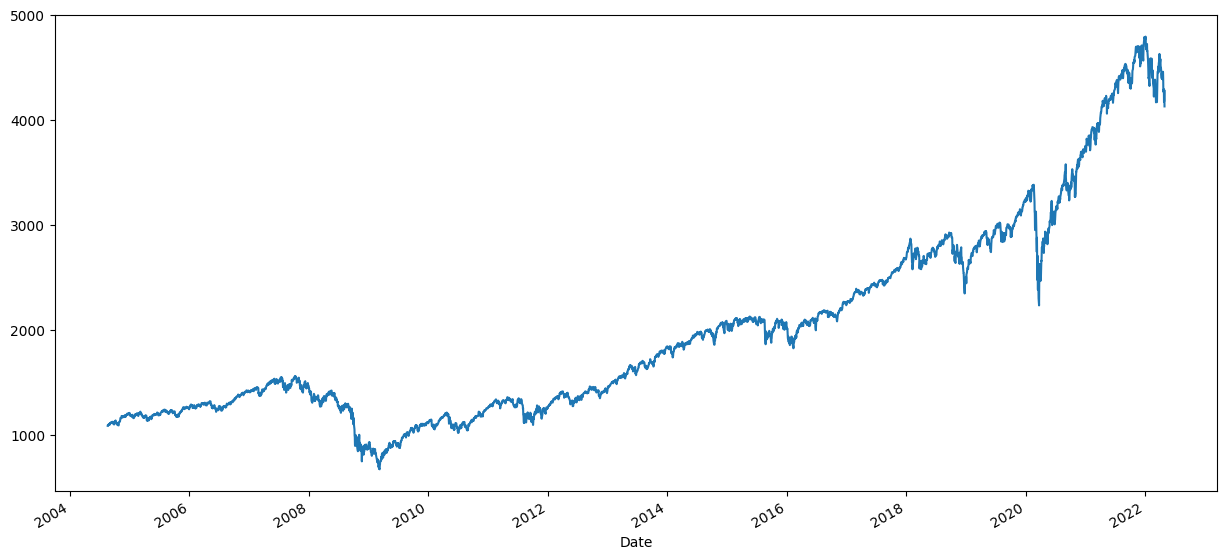

In [2]:
import yfinance as yf
from matplotlib import pyplot as plt
import pandas as pd

start = "2004-08-19"
test_start = "2022-05-01"
interval = "1d"
gspc = yf.Ticker("^GSPC")

data = gspc.history(start=start, interval=interval)

data = data.dropna()

df = data[['Close']]
df['Close_diff'] = df['Close'].diff(1)

# df_test = date index start at test_start
df_test = df[df.index >= test_start]
df = df[df.index < test_start]

df['Close'].plot(figsize=(15, 7))

In [3]:
from statsmodels.tsa.stattools import adfuller

adf_res = adfuller(df['Close'], autolag = 'AIC')
print('p-Values:' + str(adf_res[1]))

p-Values:0.995163147788377


p-Values:9.030323885010825e-26


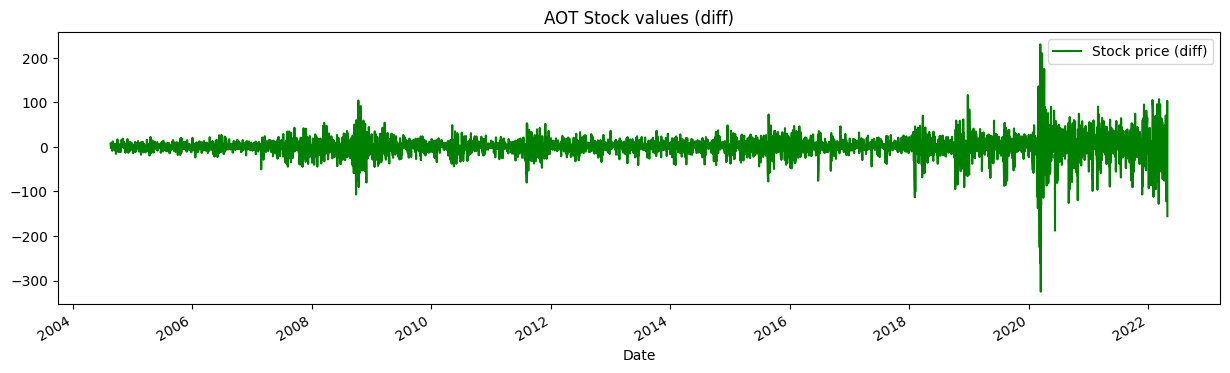

In [4]:
# df['Close_diff'] = df['Close'].diff(1)
df['Close_diff'].plot(color = 'green', figsize = (15,4))
plt.legend(['Stock price (diff)'])
plt.title('AOT Stock values (diff)')

adf_res = adfuller(df['Close_diff'].dropna(), autolag = 'AIC')
print('p-Values:' + str(adf_res[1]))

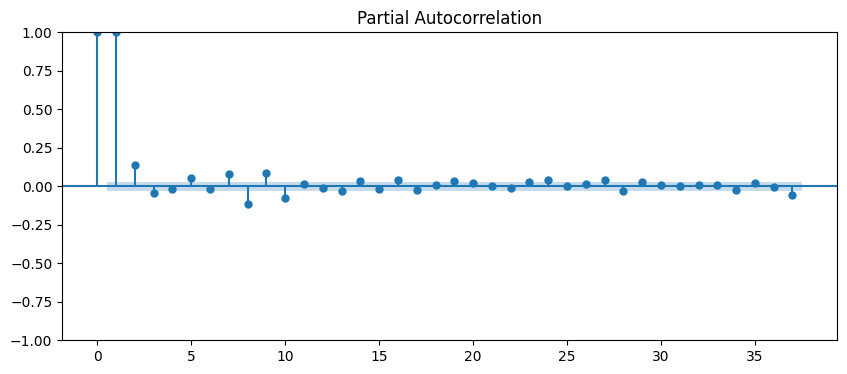

In [5]:
from statsmodels.graphics.tsaplots import  plot_pacf
from statsmodels.tsa.stattools import pacf

plt.rcParams.update({'figure.figsize':(10,4)})
plot_pacf(df['Close'].dropna(), method = 'ols')
df_pacf = pacf(df['Close'].dropna(), method = 'ols')

In [6]:
import numpy as np

for i in range(0, len(df_pacf)):
    if df_pacf[i] < 1.96 / np.sqrt(len(df['Close'])):
        print('p =',i - 1)
        break

p = 2


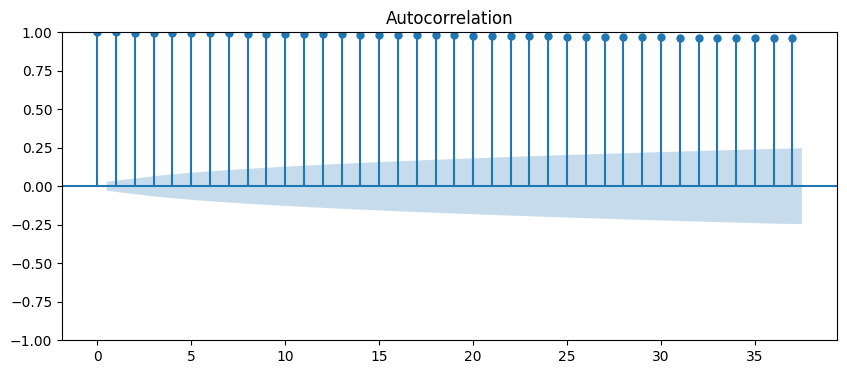

In [7]:

#Moving Average (q)
from statsmodels.graphics.tsaplots import  plot_acf
from statsmodels.tsa.stattools import acf

plt.rcParams.update({'figure.figsize':(10,4)})
plot_acf(df['Close'], fft = True)
df_acf = acf(df['Close'], fft = True)

In [8]:
for i in range(0, len(df_acf)):
    if df_acf[i] < 1.96 / np.sqrt(len(df['Close'])):
        print('q=', i - 1)
        break

In [9]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
p = q = [1, 2, 3]
d = [1]
pdq = list(itertools.product(p, d, q))

aic = []

for param in pdq:
    try:
        model = ARIMA(df['Close'].dropna(), order = param)
        results = model.fit()
        a = (results.aic, param)
        aic.append(a)
    except:
        continue
aic

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[(41023.70742882274, (1, 1, 1)),
 (41021.16699896744, (1, 1, 2)),
 (41020.74127233618, (1, 1, 3)),
 (41022.63328753263, (2, 1, 1)),
 (40881.507936018854, (2, 1, 2)),
 (41018.38478743698, (2, 1, 3)),
 (40956.80346472972, (3, 1, 1)),
 (41017.600886956905, (3, 1, 2)),
 (40884.56846449389, (3, 1, 3))]

In [10]:
min_order = min(aic)[1]
print('Min AIC:', min(aic))

# aic is (value, (p, d, q))
# p is AR, q is MA, r is difference

# AR is the number of lags of Y to be used as predictors.
# what is number of lags meaning? how many previous values of Y are used to predict the current value of Y
# which mean next stock price is depend on previous stock price
# what if p is 0? it means that the current value of Y is not dependent on the previous values of Y

# q is the number of lagged forecast errors that should go into the ARIMA model
# what is the meaning of q? how many previous forecast errors are used to predict the current value of Y
# which mean the next stock price is depend on previous forecast errors
# what if q is 0? it means that the current value of Y is not dependent on the previous forecast errors

# d is the number of differencing required to make the time series stationary
# what is the meaning of d? how many times the raw observations are differenced to make the time series stationary
# what if d is 0? it means that the time series is already stationary

# what if q is 0 and p is 0? it means that the current value of Y is not dependent on the previous values of Y and previous forecast errors
# what current y depend on if q and p is 0? ans: random walk (equation: Y(t) = c + e(t))

# what is e(t)? ans: error term at time t
# how we know e(t)? ans: we can't know e(t) because it is random
# which mean e(t) is random variable
# what is c? ans: constant term

# arima 1 1 1 equation: Y(t) = c + Y(t-1) + e(t-1) + e(t)


Min AIC: (40881.507936018854, (2, 1, 2))


In [11]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
import torch

def SMAPE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(200 * torch.mean(torch.abs(pred - y) / (torch.abs(y) + torch.abs(pred))))

def RMSE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.sqrt(torch.mean((pred - y) ** 2)))

def MAE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean(torch.abs(pred - y)))

def directional_accuracy(Y_actual, Y_predicted):
    actual_changes = np.sign(np.diff(Y_actual))
    predicted_changes = np.sign(np.diff(Y_predicted))
    correct_predictions = np.sum(actual_changes == predicted_changes)
    total_predictions = len(actual_changes)
    directional_accuracy = correct_predictions / total_predictions * 100
    return directional_accuracy

def directional_accuracy_baseline(Y_actual): # only guess up or down based on previous day
    actual_changes = np.sign(np.diff(Y_actual))
    predicted_changes = np.roll(actual_changes, 1)
    correct_predictions = np.sum(actual_changes == predicted_changes)
    total_predictions = len(actual_changes)
    directional_accuracy = correct_predictions / total_predictions * 100
    return directional_accuracy



In [12]:
directional_accuracy_baseline(df['Close'])

47.22783389450056

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 4456
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -20498.891
Date:                Thu, 08 Aug 2024   AIC                          41007.782
Time:                        16:44:36   BIC                          41039.791
Sample:                             0   HQIC                         41019.067
                               - 4456                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0461      0.016    -67.141      0.000      -1.077      -1.016
ar.L2         -0.1606      0.005    -33.150      0.000      -0.170      -0.151
ma.L1         -0.0869      0.016     -5.296      0.0

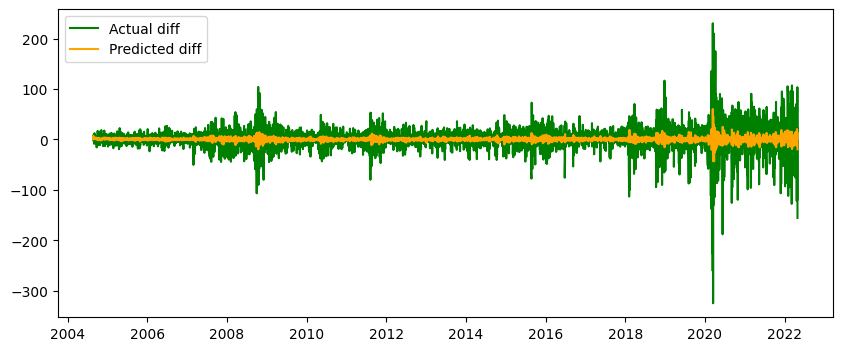

In [13]:
model = ARIMA(df['Close_diff'], order = min_order)
results = model.fit()
print(results.summary())

#Prediction
plt.figsize = (15,4)
plt.plot(df['Close_diff'], color = 'green', label = 'Actual diff')
plt.plot(results.predict(), color= 'orange', label = 'Predicted diff')
plt.legend()

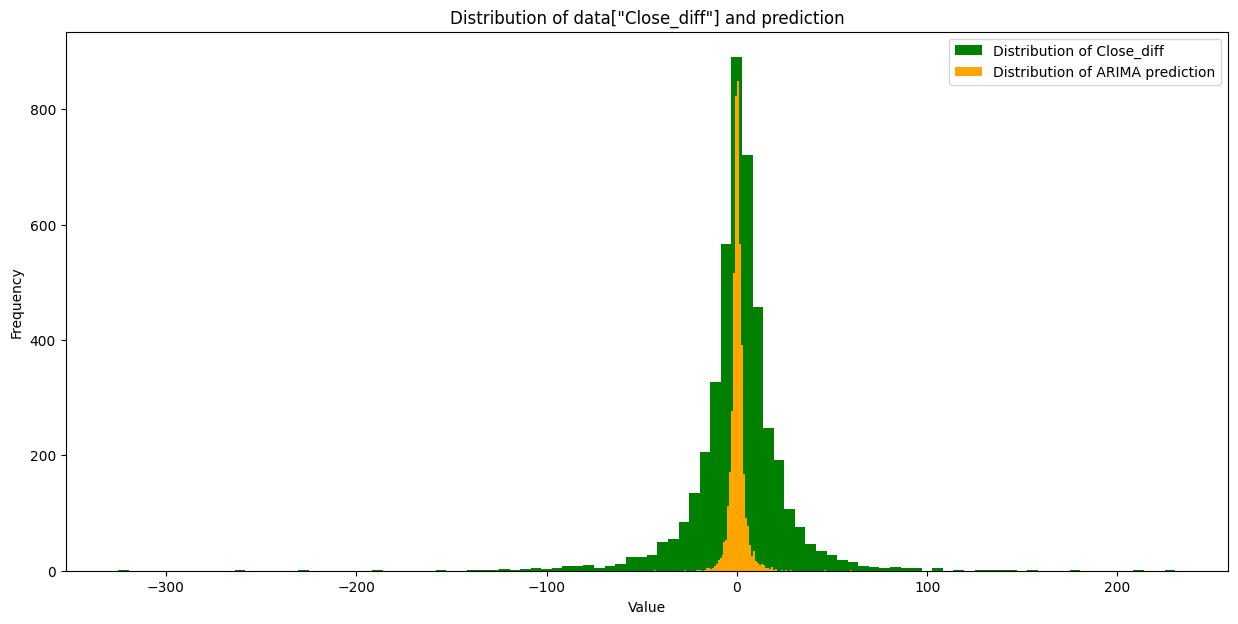

In [14]:
plt.figure(figsize=(15, 7))
plt.hist(df['Close_diff'], bins = 100, color = 'green', label="Distribution of Close_diff")
plt.hist(results.predict(), bins = 100, color = "orange", label="Distribution of ARIMA prediction")

plt.title('Distribution of data["Close_diff"] and prediction')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.legend()

In [15]:
# print mse
from sklearn.metrics import mean_squared_error
df['Close_diff'].fillna(0, inplace = True)
print('MSE:', mean_squared_error(df['Close_diff'], results.predict()))


MSE: 579.1211582989606


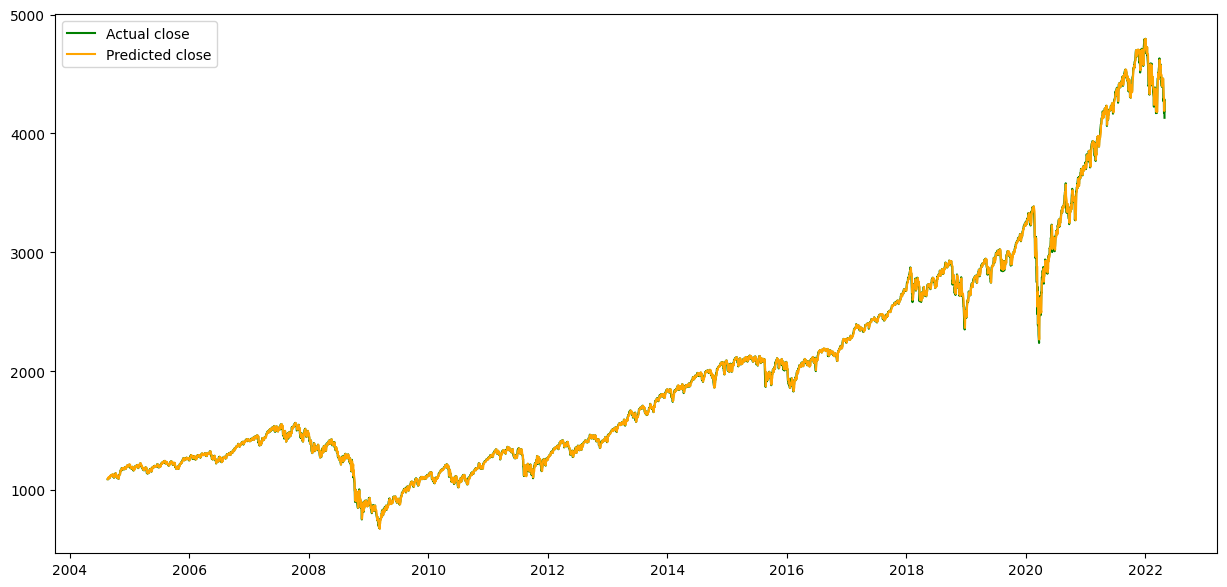

In [16]:
import pandas as pd

prediction = pd.DataFrame(columns=['Predicted'])
prediction['Predicted'] = results.predict()
df_pred = pd.merge(df, prediction, how = 'left', left_index = True, right_index = True)
df_pred['Predicted_close'] = df_pred['Close'] + df_pred['Predicted'].shift(-1)
df_pred['Predicted_close'] = df_pred['Predicted_close'].shift(1).fillna(df['Close'])
plt.figure(figsize=(15, 7))
plt.plot(df_pred['Close'], color = 'green', label = 'Actual close')
plt.plot(df_pred['Predicted_close'], color='orange', label = 'Predicted close')
plt.legend()


In [17]:
print("Error on train data")
print('MSE:', mean_squared_error(df['Close'], df_pred['Predicted_close']))
print('SMAPE:', SMAPE(df_pred['Predicted_close'], df['Close']))
print('MAE:', MAE(df_pred['Predicted_close'], df['Close']))
print('RMSE:', RMSE(df_pred['Predicted_close'], df['Close']))
print('Directional Accuracy:', directional_accuracy(df['Close'], df_pred['Predicted_close']))

Error on train data
MSE: 579.1211582989605


<ipython-input-11-436a6f5f3b16>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = torch.tensor(pred)
<ipython-input-11-436a6f5f3b16>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(y)


SMAPE: 0.7728605180905627
MAE: 14.629983003448583


<ipython-input-11-436a6f5f3b16>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = torch.tensor(pred)
<ipython-input-11-436a6f5f3b16>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(y)
<ipython-input-11-436a6f5f3b16>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = torch.tensor(pred)
<ipython-input-11-436a6f5f3b16>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a f

RMSE: 24.064936282877635
Directional Accuracy: 48.058361391694724


# **Evaluation**

<Axes: xlabel='Date'>

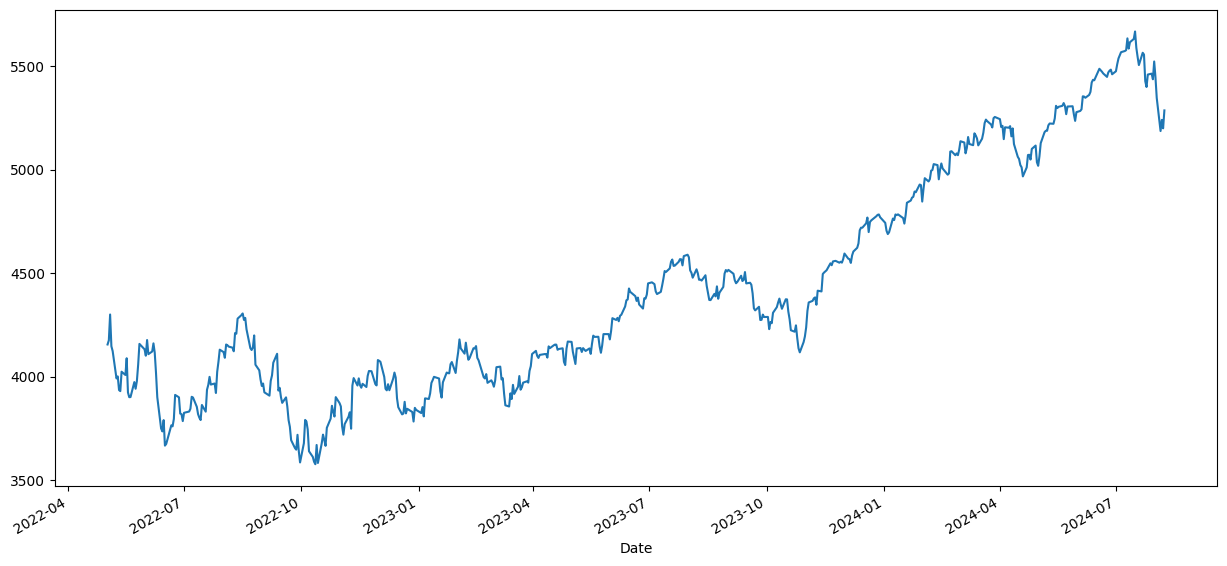

In [18]:
df_test['Close'].plot(figsize=(15, 7))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


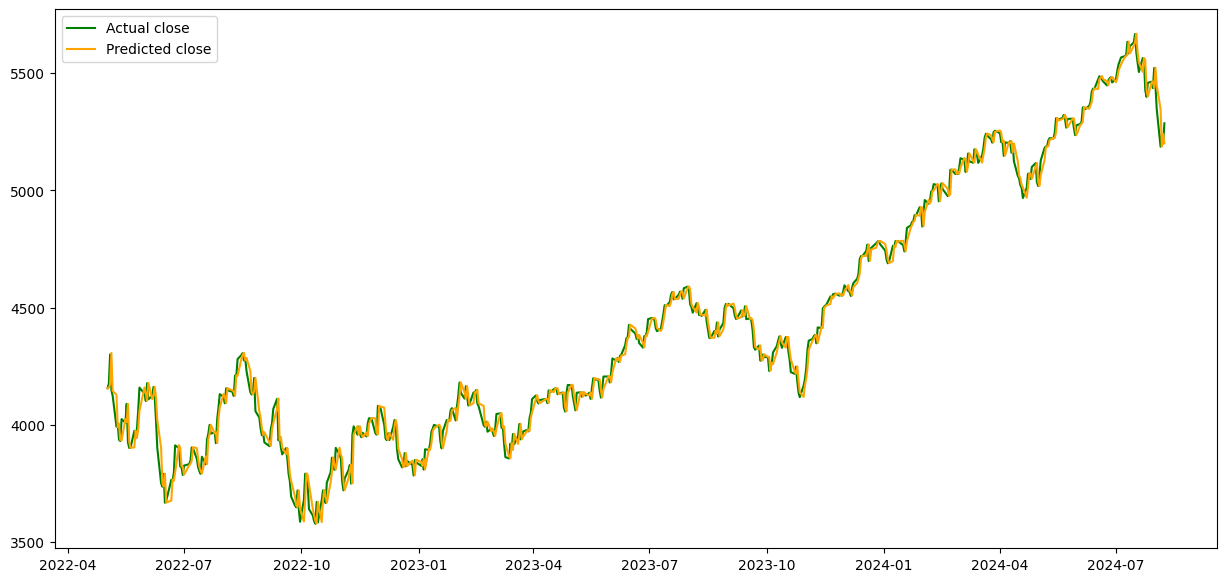

In [19]:
# prediction by arima without seen the future
prediction = pd.DataFrame(columns=['Predicted'])
df_all = pd.concat([df, df_test])
prediction['Predicted'] = results.predict(start = len(df), end = len(df_all) - 1)

df_test_pred = df_test[["Close","Close_diff"]].copy()
df_test_pred = df_test_pred.reset_index()
df_test_pred["Predicted"] = prediction["Predicted"].values
df_test_pred.set_index("Date", inplace=True)

df_test_pred['Predicted_close'] = df_test_pred['Close'] + df_test_pred['Predicted'].shift(-1)
df_test_pred['Predicted_close'] = df_test_pred['Predicted_close'].shift(1).fillna(df_test['Close'])
plt.figure(figsize=(15, 7))
plt.plot(df_test_pred['Close'], color = 'green', label = 'Actual close')
plt.plot(df_test_pred['Predicted_close'], color='orange', label = 'Predicted close')
plt.legend()

In [20]:
prediction['Predicted']

,Predicted
4456,24.213403
4457,1.876814
4458,-3.636258
4459,5.718708
4460,-3.181636
...,...
5022,1.004405
5023,1.004405
5024,1.004405
5025,1.004405


In [21]:
df_test

,Close,Close_diff
Date,,
2022-05-02 00:00:00-04:00,4155.379883,23.449707
2022-05-03 00:00:00-04:00,4175.479980,20.100098
2022-05-04 00:00:00-04:00,4300.169922,124.689941
2022-05-05 00:00:00-04:00,4146.870117,-153.299805
2022-05-06 00:00:00-04:00,4123.339844,-23.530273
...,...,...
2024-08-02 00:00:00-04:00,5346.560059,-100.120117
2024-08-05 00:00:00-04:00,5186.330078,-160.229980
2024-08-06 00:00:00-04:00,5240.029785,53.699707


In [22]:
df_test_pred

,Close,Close_diff,Predicted,Predicted_close
Date,,,,
2022-05-02 00:00:00-04:00,4155.379883,23.449707,24.213403,4155.379883
2022-05-03 00:00:00-04:00,4175.479980,20.100098,1.876814,4157.256697
2022-05-04 00:00:00-04:00,4300.169922,124.689941,-3.636258,4171.843722
2022-05-05 00:00:00-04:00,4146.870117,-153.299805,5.718708,4305.888630
2022-05-06 00:00:00-04:00,4123.339844,-23.530273,-3.181636,4143.688481
...,...,...,...,...
2024-08-02 00:00:00-04:00,5346.560059,-100.120117,1.004405,5447.684581
2024-08-05 00:00:00-04:00,5186.330078,-160.229980,1.004405,5347.564464
2024-08-06 00:00:00-04:00,5240.029785,53.699707,1.004405,5187.334483


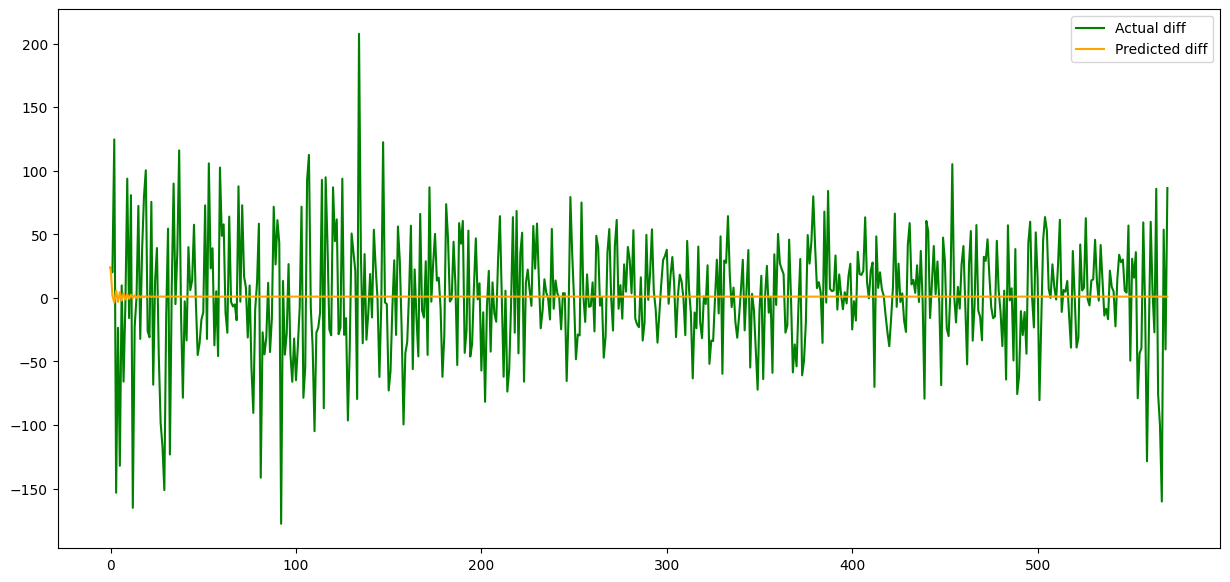

In [23]:
# plot between real_diff and predicted_diff
plt.figure(figsize=(15, 7))
df_test_pred.reset_index(drop=True, inplace=True)
prediction.reset_index(drop=True, inplace=True)

df_test_pred['Predicted_diff'] = prediction['Predicted']

plt.plot(df_test_pred['Close_diff'], color = 'green', label = 'Actual diff')
plt.plot(df_test_pred['Predicted_diff'], color='orange', label = 'Predicted diff')
plt.legend()



In [24]:
df_test_pred

,Close,Close_diff,Predicted,Predicted_close,Predicted_diff
0,4155.379883,23.449707,24.213403,4155.379883,24.213403
1,4175.479980,20.100098,1.876814,4157.256697,1.876814
2,4300.169922,124.689941,-3.636258,4171.843722,-3.636258
3,4146.870117,-153.299805,5.718708,4305.888630,5.718708
4,4123.339844,-23.530273,-3.181636,4143.688481,-3.181636
...,...,...,...,...,...
566,5346.560059,-100.120117,1.004405,5447.684581,1.004405
567,5186.330078,-160.229980,1.004405,5347.564464,1.004405
568,5240.029785,53.699707,1.004405,5187.334483,1.004405
569,5199.500000,-40.529785,1.004405,5241.034190,1.004405


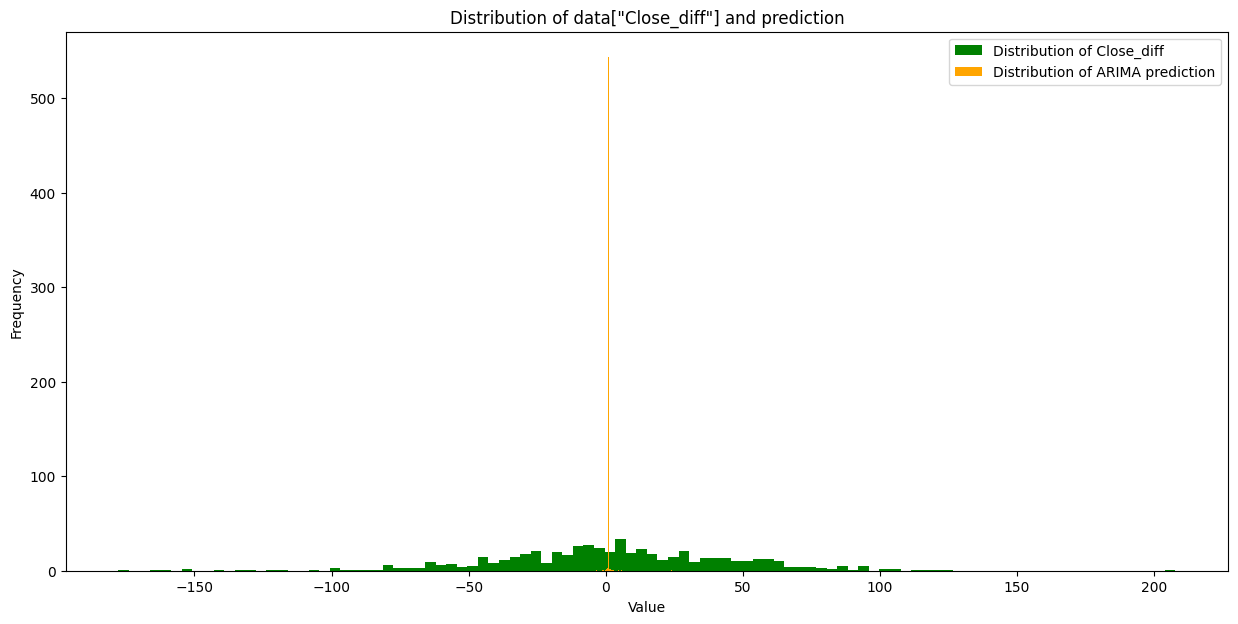

In [25]:
# plot distribution
plt.figure(figsize=(15, 7))
plt.hist(df_test_pred['Close_diff'], bins = 100, color = 'green', label="Distribution of Close_diff")
plt.hist(df_test_pred['Predicted_diff'], bins = 100, color = "orange", label="Distribution of ARIMA prediction")

plt.title('Distribution of data["Close_diff"] and prediction')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.legend()

In [26]:
print("error on test data:")
# print(type(df_test_pred['Predicted_close']) , type(df_test["Close"]))
print('SMAPE:', SMAPE(df_test_pred['Predicted_close'], df_test['Close']))
print('MAE:', MAE(df_test_pred['Predicted_close'], df_test['Close']))
print('RMSE:', RMSE(df_test_pred['Predicted_close'], df_test['Close']))
print('Directional Accuracy:', directional_accuracy(df_test['Close'], df_test_pred['Predicted_close']))


error on test data:
SMAPE: 0.8018403667040227
MAE: 34.315934509311994
RMSE: 45.89771569467396
Directional Accuracy: 49.824561403508774


<ipython-input-11-436a6f5f3b16>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(y)
<ipython-input-11-436a6f5f3b16>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(y)
<ipython-input-11-436a6f5f3b16>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(y)


In [46]:
def buy_sell_stock_v2(prices,real):
    buy_days = []
    sell_days = []
    current_bought= None
    returns = []
    real_current_bought= None
    real_returns = []
    holding = False  # Flag to indicate if we're holding a stock

    for i in range(len(prices)-1):
        if  holding and real[i] > prices[i + 1] :
            holding = False
            sell_days.append(prices.index[i])
            # Calculating rate of return
            returns.append(((prices[i] - current_bought) / current_bought)+1)
            real_returns.append(((real[i] - real_current_bought) / real_current_bought)+1)

        elif not holding and real[i] < prices[i + 1]:
            buy_days.append(prices.index[i])
            holding = True
            current_bought = prices[i]
            real_current_bought = real[i]

    returns = np.array(returns)
    # print(returns)
    expected_return = (np.prod(returns)-1)*100
    max_expected_return = (returns.max()-1)*100

    real_returns = np.array(real_returns)
    real_return = (np.prod(real_returns)-1)*100
    max_real_return =(real_returns.max()-1)*100
    return buy_days, sell_days, expected_return,real_return,max_expected_return,max_real_return,returns,real_returns

def plot_stock_prices(prices,real, buy_days, sell_days):
    plt.figure(figsize=(30, 10))
    plt.plot(prices.index, prices.values, label='Pred Stock Prices')
    plt.plot(real.index, real.values, label='Real Stock Prices')
    plt.scatter(buy_days, prices.loc[buy_days], color='green', marker='^', label='Buy')
    plt.scatter(sell_days, prices.loc[sell_days], color='red', marker='v', label='Sell')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Prices with Buy/Sell Signals')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [47]:
buy_days, sell_days, expected_return, real_return,max_expected_return,max_real_return,returns,real_returns =  buy_sell_stock_v2( df_test_pred['Predicted_close'], df_test['Close'] )
print("expected_return =",expected_return,"%")
print("real_return =",real_return,"%")
print("max_expected_return =",max_expected_return,"%")
print("max_real_return =",max_real_return,"%")

expected_return = 2.9221639390590637 %
real_return = -3.6399776776530612 %
max_expected_return = 3.2130855538592407 %
max_real_return = 2.386969542307149 %


In [54]:
df_test['Close'].reset_index(drop=True, inplace=True)
df_test["Close"].head()

,Close
0,4155.379883
1,4175.479980
2,4300.169922
3,4146.870117
4,4123.339844


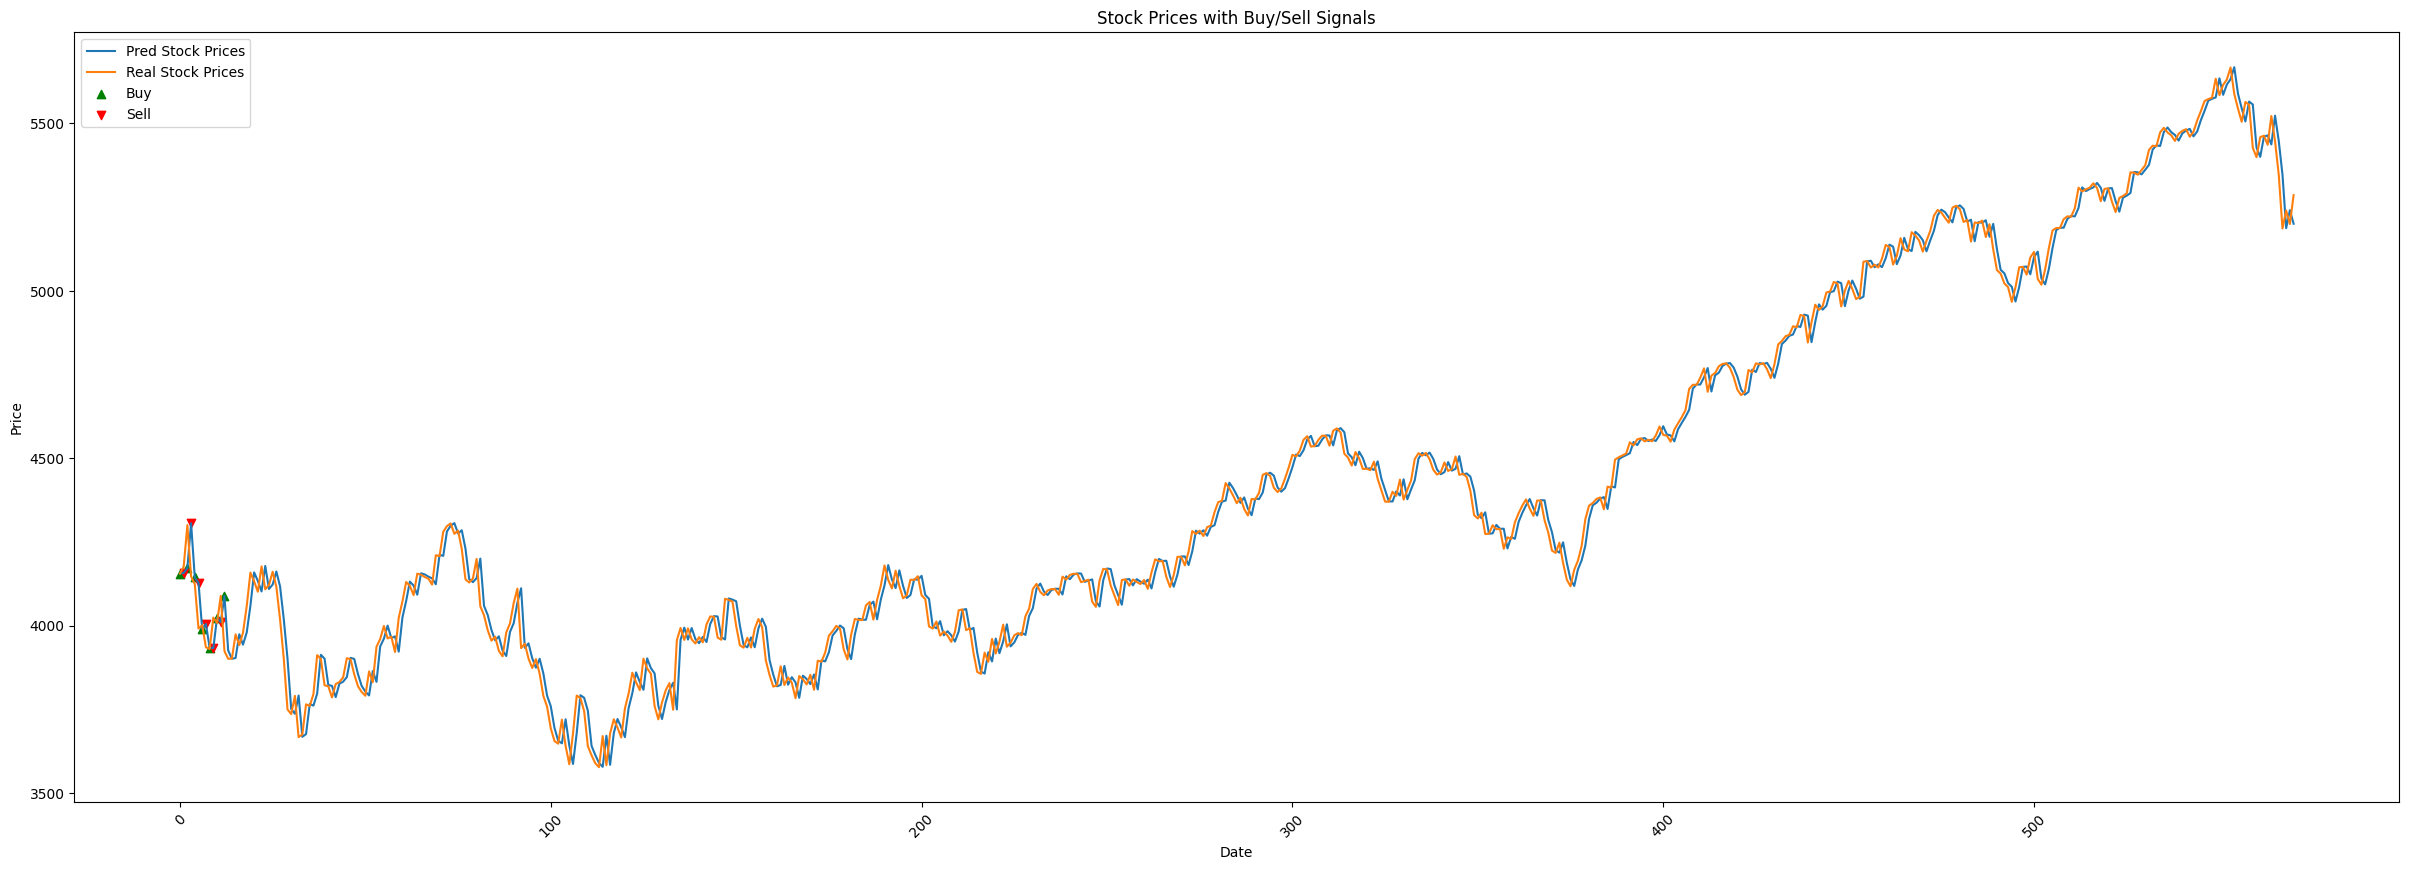

In [49]:
plot_stock_prices( df_test_pred['Predicted_close'], df_test['Close'], buy_days, sell_days)

In [50]:
def buy_sell_stock(prices,real):
    buy_days = []
    sell_days = []
    current_bought= None
    returns = []
    real_current_bought= None
    real_returns = []
    holding = False  # Flag to indicate if we're holding a stock

    for i in range(1, len(prices)-1):
        if  holding and prices[i] > prices[i - 1] and prices[i] > prices[i + 1]:
            holding = False
            sell_days.append(prices.index[i])
            # Calculating rate of return
            returns.append(((prices[i] - current_bought) / current_bought)+1)
            real_returns.append(((real[i] - real_current_bought) / real_current_bought)+1)

        elif not holding and prices[i] < prices[i - 1] and prices[i] < prices[i + 1]:
            buy_days.append(prices.index[i])
            holding = True
            current_bought = prices[i]
            real_current_bought = real[i]

    returns = np.array(returns)
    expected_return = (np.prod(returns)-1)*100
    max_expected_return = (returns.max()-1)*100

    real_returns = np.array(real_returns)
    real_return = (np.prod(real_returns)-1)*100
    max_real_return =(real_returns.max()-1)*100
    return buy_days, sell_days, expected_return,real_return,max_expected_return,max_real_return,returns,real_returns

In [53]:
buy_days, sell_days, expected_return, real_return,max_expected_return,max_real_return,returns,real_returns =  buy_sell_stock( df_test_pred['Predicted_close'], df_test['Close'] )
print("expected_return =",expected_return,"%")
print("real_return =",real_return,"%")
print("max_expected_return =",max_expected_return,"%")
print("max_real_return =",max_real_return,"%")

expected_return = 957.6373686925882 %
real_return = 5.25716645728842 %
max_expected_return = 6.517002529757154 %
max_real_return = 4.332567306803292 %


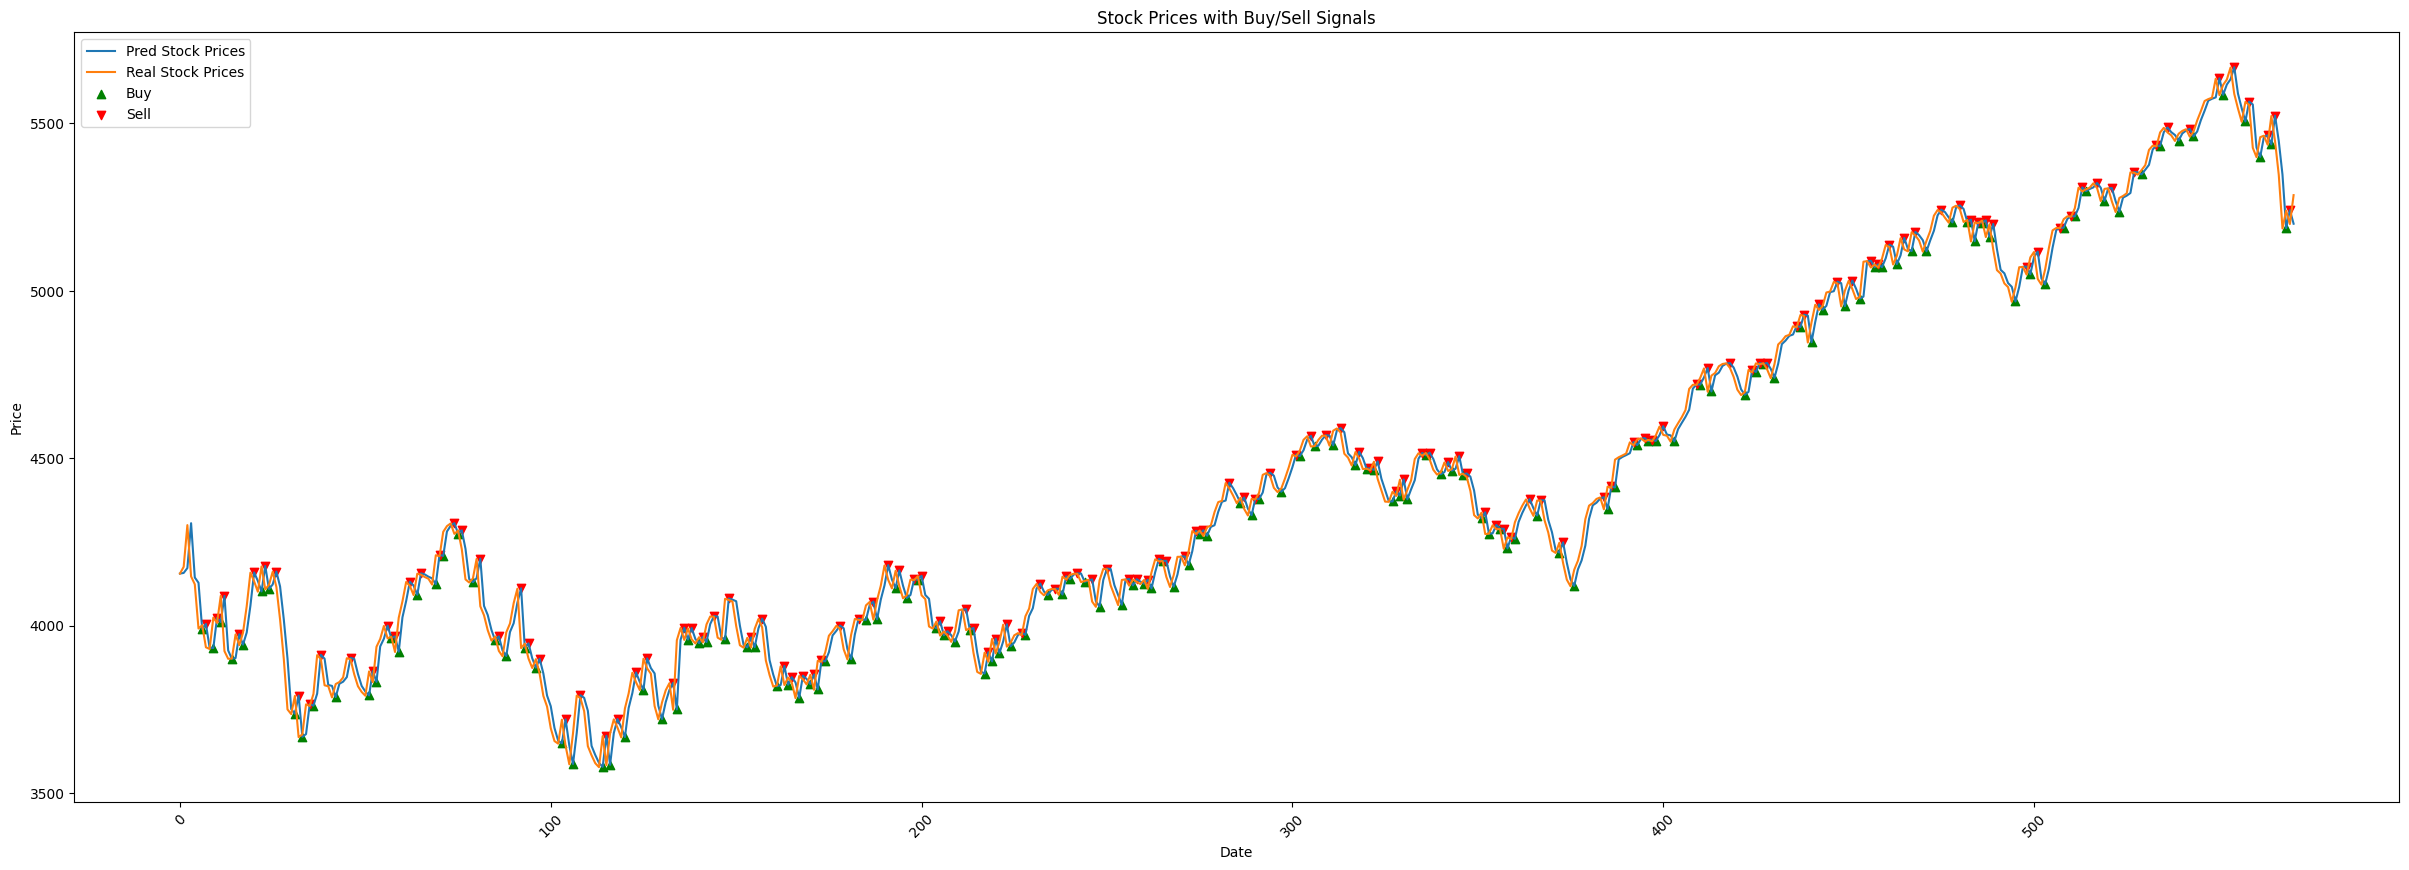

In [52]:
plot_stock_prices( df_test_pred['Predicted_close'], df_test['Close'], buy_days, sell_days)